### Libs

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem
from labicompare.visualization import critical_difference_diagram

In [14]:
# Load files
df_drcif    = pd.read_csv("./DrCIF/DrCIF_summary_results.csv")
df_rocket50 = pd.read_csv("./DrRocket_50kernels/50kernels_summary_results.csv")
df_rocket4  = pd.read_csv("./DrRocket_4kernels/4kernels_summary_results.csv")
df_rocket100 = pd.read_csv("./DrRocket_100kernels/100kernels_summary_results.csv")

In [15]:
# Add "algorithm" column to identify each experiment
df_drcif["algorithm"]   = "DrCIF"
df_rocket4["algorithm"] = "DrCIF+ROCKET4"
df_rocket50["algorithm"]= "DrCIF+ROCKET50"
df_rocket100["algorithm"]= "DrCIF+ROCKET100"

In [16]:
# Concatenate into a single dataframe
df = pd.concat([df_drcif, df_rocket4, df_rocket50, df_rocket100], ignore_index=True)

### Accuracy comparison by dataset

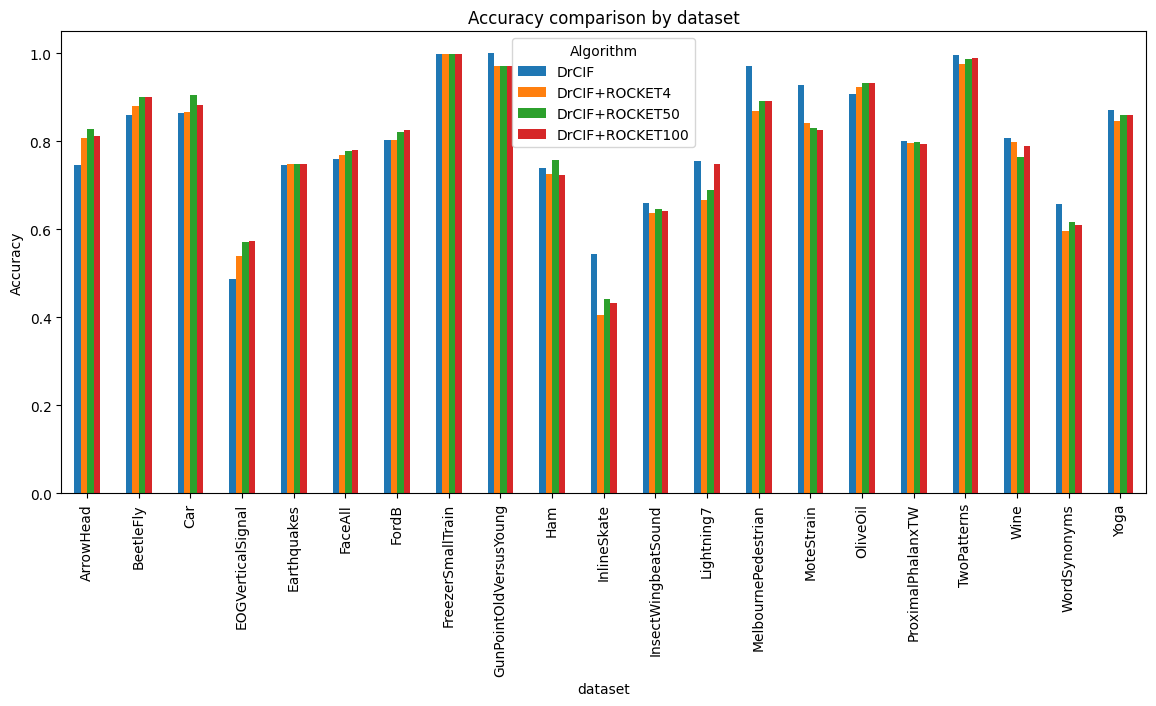

In [17]:
order_algorithms = ["DrCIF", "DrCIF+ROCKET4", "DrCIF+ROCKET50", "DrCIF+ROCKET100"]

pivot = df.pivot(index="dataset", columns="algorithm", values="accuracy_mean")

# Reorder columns after pivot
pivot = pivot[order_algorithms]

pivot.plot(kind="bar", figsize=(14, 6))
plt.title("Accuracy comparison by dataset")
plt.ylabel("Accuracy")
plt.legend(title="Algorithm")
plt.show()


### Ranking heatmap by dataset

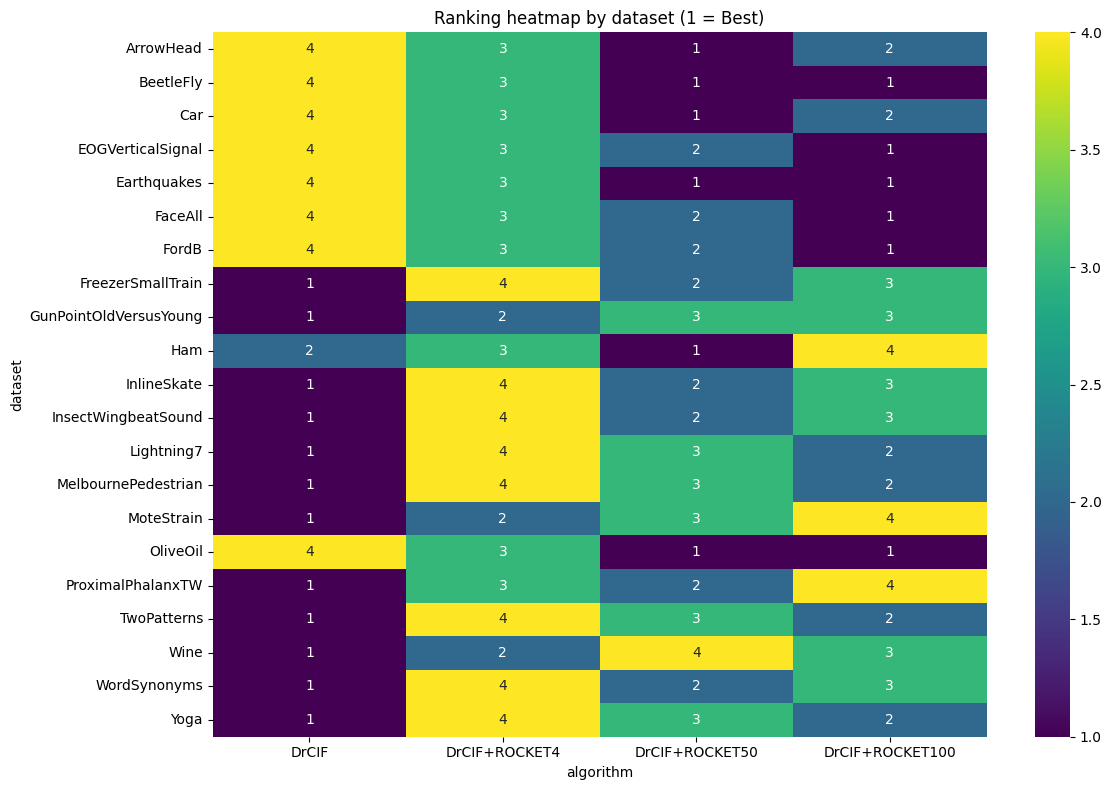

In [18]:
rankings = df.groupby("dataset")["accuracy_mean"].rank(ascending=False, method="min")
rankings = rankings.to_frame()  # Convert Series to DataFrame
rankings["algorithm"] = df["algorithm"]
rankings["dataset"] = df["dataset"]

# Create the pivot for the rankings heatmap
pivot_rank = rankings.pivot(index="dataset", columns="algorithm", values="accuracy_mean")

# Reorder columns
pivot_rank = pivot_rank[order_algorithms]

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rank, annot=True, cmap="viridis", cbar=True)
plt.title("Ranking heatmap by dataset (1 = Best)")
plt.tight_layout()
plt.show()

## Quick Recap: What DrCIF Does Well

* It combines **random intervals** from the time series with **statistical features** (like those from Catch22 in the original).
* It is **strong at capturing repetitive local patterns** (shapes, subsequences).
* However:

  * It may struggle when the dataset depends on **global information** (not just short intervals).
  * It suffers in datasets with **high noise**, **few training examples**, or **very similar classes**.

---

## Where It Performed Well (Favorable Datasets)

1. **FreezerSmallTrain, GunPointOldVersusYoung, Lightning7, Wine, OliveOil**

   * **Short** time series with **well-defined local patterns**.
   * Example: In GunPoint, there are characteristic movements at specific time points → DrCIF can capture this via intervals.

2. **TwoPatterns, InsectWingbeatSound, MoteStrain, ProximalPhalanxTW**

   * Series with **repetitive patterns** or **distinct local shapes**.
   * TwoPatterns has clear alternating subsequences → perfect for random intervals.
   * InsectWingbeatSound has acoustic signatures → local intervals carry significant information.

3. **Yoga, WordSynonyms, MelbournePedestrian, InlineSkate**

   * Longer series, but with **characteristic segments within the timeline**.
   * For example, Yoga has repeated movements in certain parts of the series; MelbournePedestrian captures pedestrian flow variations that have local patterns.

**Summary of this group:** DrCIF performs well when **local shapes or short subsequences distinguish classes**.

---

## Where It Performed Poorly (Unfavorable Datasets)

1. **ArrowHead, Car, BeetleFly, Ham, FaceAll**

   * **Very short** series (ArrowHead, Car, BeetleFly) or with **many similar classes** (Ham, FaceAll).
   * In these cases, the intervals don't capture sufficient discriminative power.

2. **EOGVerticalSignal, Earthquakes**

   * **Long, noisy** series with **low-frequency patterns**.
   * DrCIF tends to capture too much random noise → loses the global pattern.

3. **FordB**

   * **Large, noisy, multiclass dataset with imbalance**.
   * The discriminative pattern is more **global** (engine conditions over time) than local → DrCIF misses it.

**Summary of this group:** It struggles with series that require **global characteristics**, **very noisy datasets**, or **very similar classes** (where random intervals are insufficient).

---

## Synthesis

* **DrCIF works best** in datasets where **small segments** (subsequences) carry the discriminative signal → like TwoPatterns, GunPoint, InsectWingbeatSound.
* **Performs poorly** when it's necessary to look at the series **as a whole** or when noise dominates (FordB, EOG, Earthquakes).

### Average training and testing time per algorithm

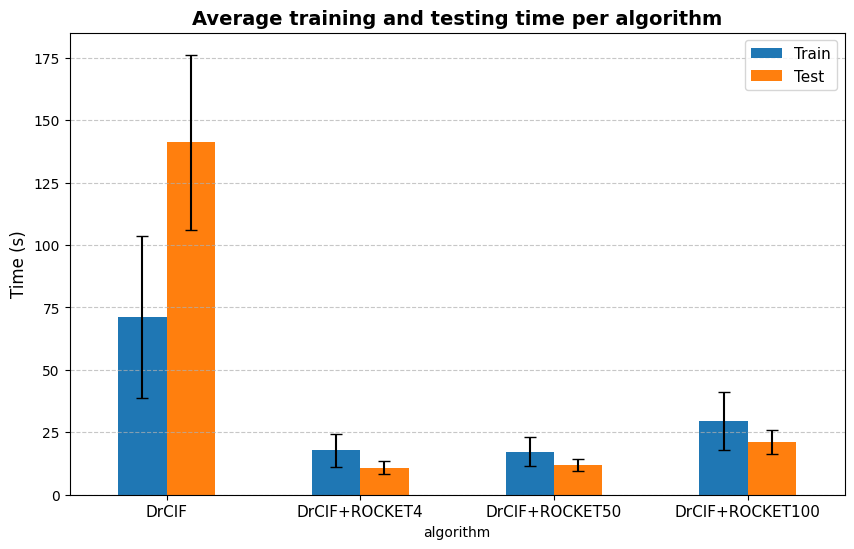

In [19]:
tempo_means = df.groupby("algorithm")[["train_time_mean","test_time_mean"]].mean().loc[order_algorithms]
tempo_sems  = df.groupby("algorithm")[["train_time_mean","test_time_mean"]].sem().loc[order_algorithms]

tempo_means.plot(
    kind="bar",
    yerr=tempo_sems, 
    figsize=(10,6),
    capsize=4,
    color=["#1f77b4", "#ff7f0e"] 
)

plt.title("Average training and testing time per algorithm", fontsize=14, weight="bold")
plt.ylabel("Time (s)", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.legend(["Train", "Test"], fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Scatter time × accuracy

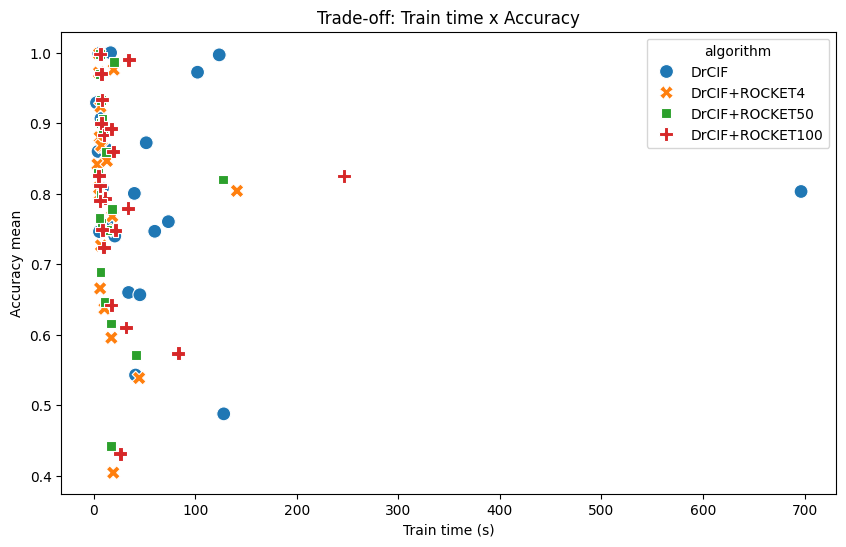

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x="train_time_mean", y="accuracy_mean",
    hue="algorithm", style="algorithm", s=100,
    hue_order=order_algorithms, style_order=order_algorithms
)
plt.title("Trade-off: Train time x Accuracy")
plt.xlabel("Train time (s)")
plt.ylabel("Accuracy mean")
plt.show()

**Identified Patterns:**

1 - **Most points are concentrated between 0 and 100s on the X-axis**
→ This shows that for most datasets, training time didn't explode, even with more kernels.
Only a few datasets were outliers, exceeding 200s or even reaching ~700s.

2 - **Pure DrCIF (blue)**
- Shows considerable time variation (some very fast training times, others up to 700s).
- In terms of accuracy, it doesn't dominate — many blue points remain below other algorithms (e.g., some around 0.5–0.7).

3 - **DrCIF+ROCKET4 (orange)**
- Minimal additional time cost (almost all points near 0–50s).
- Improves accuracy in some datasets (fewer points below 0.7).
- Appears to offer good cost-benefit ratio.

4 - **DrCIF+ROCKET50 (green)**
- Maintains relatively low times, but increases in some datasets (some around 100–150s).
- Tends to be among the best performers in accuracy (above 0.9 in many datasets).

5 - **DrCIF+ROCKET100 (red)**
- Shows a clear trade-off: some points had significantly higher costs (one dataset ~250s and another ~700s).
- Generally achieves high accuracy, but not always superior to ROCKET50 → meaning increasing kernels doesn't always guarantee better performance, but substantially increases time.

**Overall Interpretation:**

The graph shows the classic trade-off:

More kernels → longer training time → sometimes only marginal gains in accuracy.

**DrCIF+ROCKET4** is fast and already shows improvement over pure DrCIF.

**DrCIF+ROCKET50** appears to be a good middle ground: higher cost than 4 kernels, but without exploding like 100 kernels.

**DrCIF+ROCKET100** is only worthwhile if you truly need every extra decimal of accuracy, as it can cost up to 10× more time in certain datasets.

**Conclusion:** Increasing the number of kernels provides accuracy gains in some cases, but comes with significant growth in training time. The optimal balance appears to be around 50 kernels, where we see consistent improvement without explosive cost increases.

### Time ranking heatmap

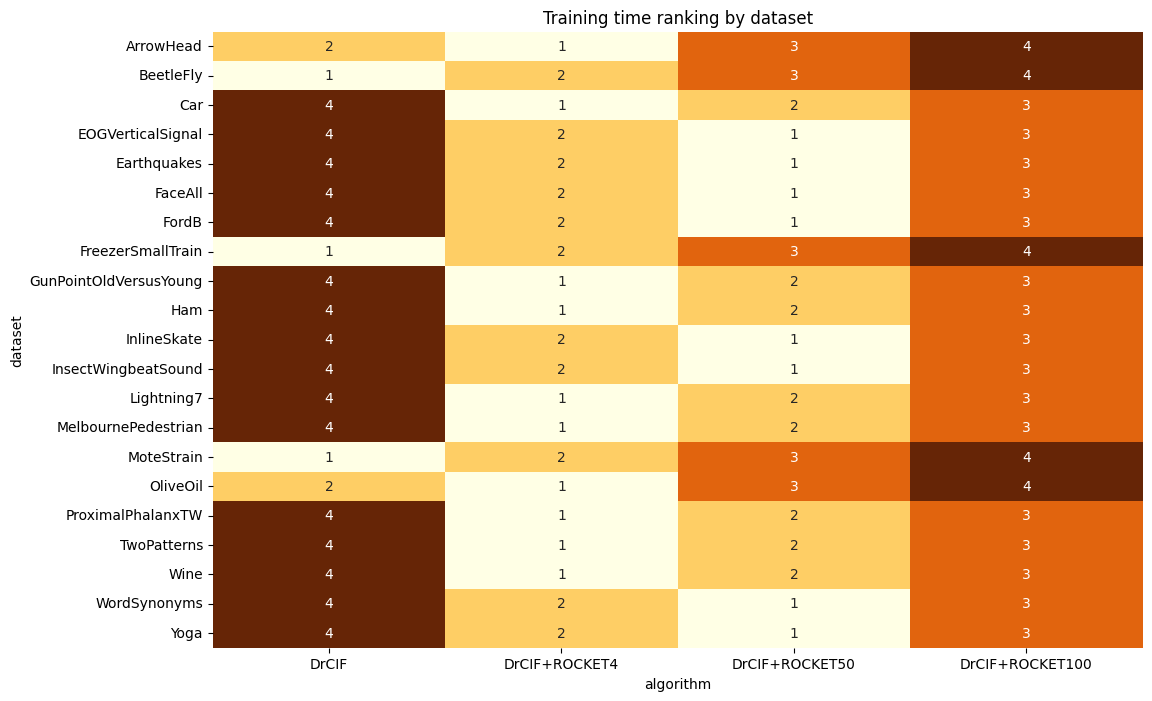

In [21]:
rankings_time = df.groupby("dataset")[["train_time_mean","test_time_mean"]].rank(ascending=True, method="min")
rankings_time["algorithm"] = df["algorithm"]
rankings_time["dataset"] = df["dataset"]

pivot_rank_time = rankings_time.pivot(index="dataset", columns="algorithm", values="train_time_mean")
pivot_rank_time = pivot_rank_time[order_algorithms]  # garantir ordem

plt.figure(figsize=(12,8))
sns.heatmap(pivot_rank_time, annot=True, cmap="YlOrBr", cbar=False)
plt.title("Training time ranking by dataset")
plt.show()

### Critical Difference Diagram


=== Critical Difference Diagram for accuracy_mean ===


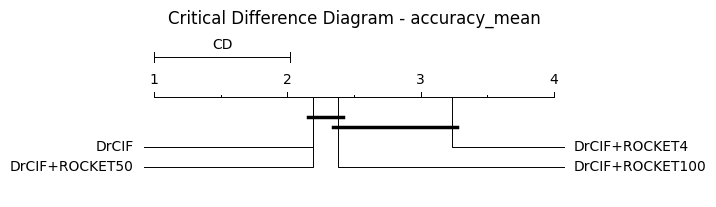


=== Critical Difference Diagram for precision_mean ===


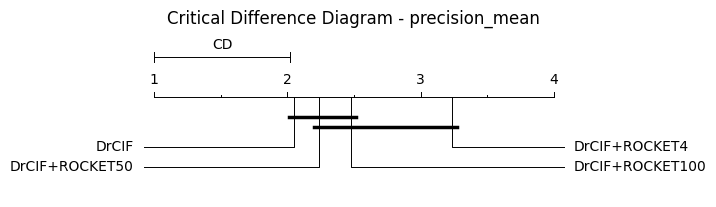


=== Critical Difference Diagram for recall_mean ===


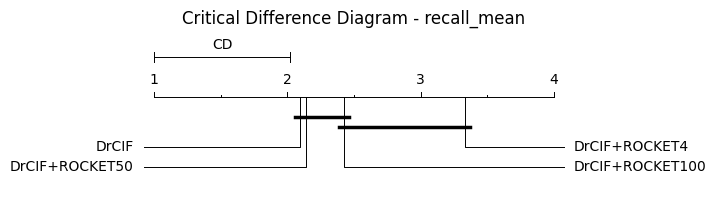

In [22]:
from labicompare.visualization import critical_difference_diagram

# Lista das métricas que você quer avaliar
metricas = ["accuracy_mean", "precision_mean", "recall_mean"]

for metrica in metricas:
    print(f"\n=== Critical Difference Diagram for {metrica} ===")

    # Pivotar para dataset × algoritmos
    metrics = df.pivot(index="dataset", columns="algorithm", values=metrica)

    # Gerar CD diagram
    fig = critical_difference_diagram(
        metrics=metrics,
        test="nemenyi",
        alpha=0.05
    )
    
    plt.title(f"Critical Difference Diagram - {metrica}")
    plt.show()
